In [8]:
NUM = 14

In [ ]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from PIL import Image
from skimage import morphology, filters
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm  # 导入tqdm库

# 定义数据集路径
data_folder = 'data/mnist14'
x_data = []
y_data = []
x_data_original = []  # 用于存储原始图像

# 定义细化处理函数
def thin_image(image):
    binary_image = image > filters.threshold_otsu(image)
    skeleton = morphology.skeletonize(binary_image)
    thin_image = (skeleton * 255).astype(np.uint8)
    return thin_image

# 加载图像和标签
for label in range(NUM):
    label_folder = os.path.join(data_folder, str(label))
    images = []
    original_images = []

    # 使用tqdm显示进度条
    for img_name in tqdm(os.listdir(label_folder), desc=f'Loading images for label {label}'):
        img_path = os.path.join(label_folder, img_name)
        
        # 加载并处理图像
        image = Image.open(img_path).convert('L')  # 转换为灰度图
        image = image.resize((28, 28))  # 调整大小
        image_array = np.array(image)
        
        # 存储原始图像
        original_images.append(image_array)
        
        # 细化处理
        image_array = thin_image(image_array)
        
        images.append(image_array)
    
    x_data.extend(images)
    y_data.extend([label] * len(images))
    x_data_original.extend(original_images)

# 转换为NumPy数组
x_data = np.array(x_data)
y_data = np.array(y_data)
x_data_original = np.array(x_data_original)

# 直接使用所有样本
x_balanced = x_data
y_balanced = y_data

# 按比例拆分数据集（例如，80% 训练集，20% 测试集）
x_train, x_test, y_train, y_test = train_test_split(x_balanced, y_balanced, test_size=0.2, random_state=42)

# 确保数据集的形状符合TensorFlow的要求
x_train = x_train.reshape(-1, 28, 28, 1).astype('float32') 
x_test = x_test.reshape(-1, 28, 28, 1).astype('float32')

# 创建一个ImageDataGenerator实例并设置增强参数
datagen = ImageDataGenerator(
    # rotation_range=1,
    # zoom_range=(0.8, 1.0),
    width_shift_range=0.1,
    height_shift_range=0.1
)
# 适配数据生成器
datagen.fit(x_train)

# 打印每种图片的数量
unique, counts = np.unique(y_balanced, return_counts=True)
print("每种图片数量:")
for label, count in zip(unique, counts):
    print(f'类别 {label}: {count} 张')


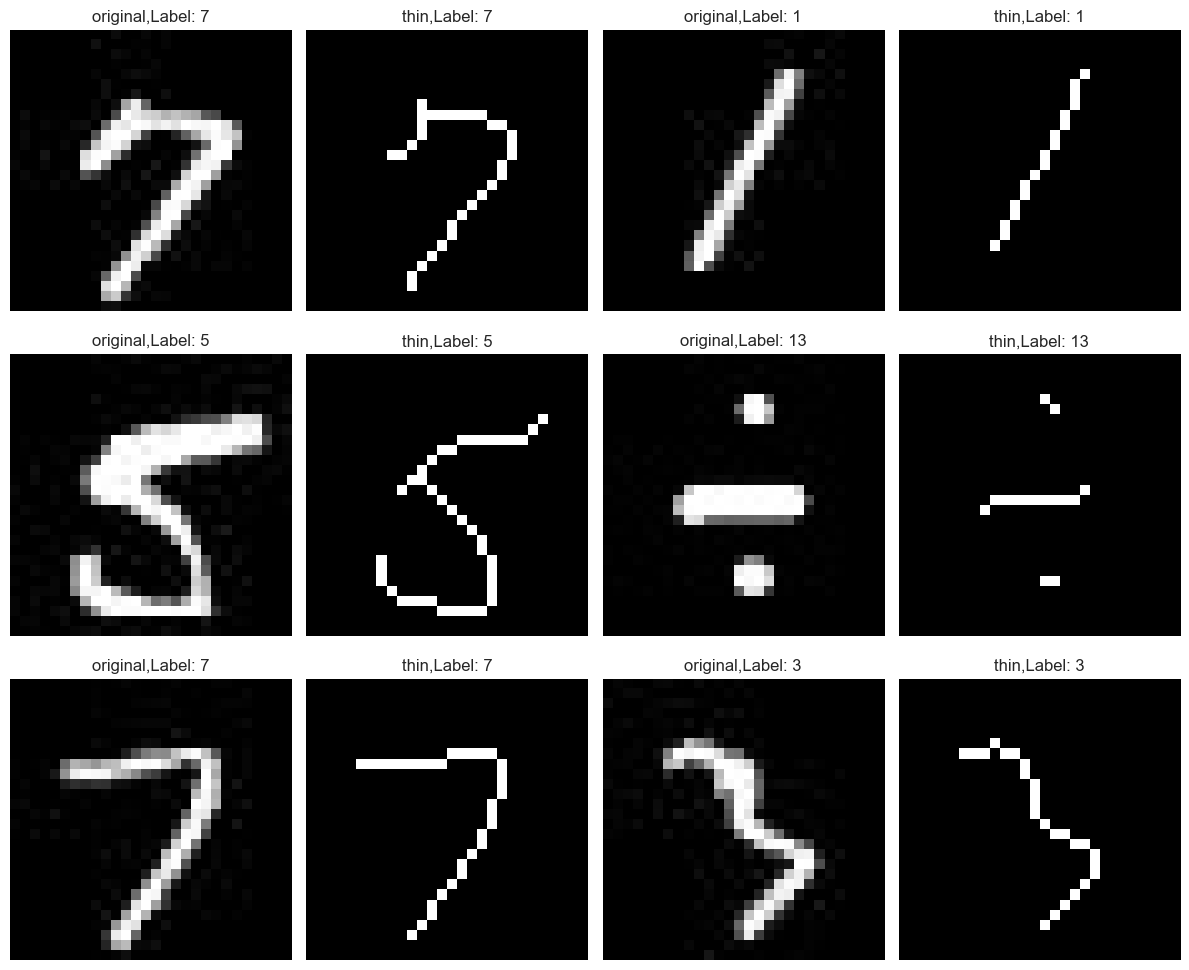

In [10]:
# 显示几个原始图像与细化后的对比图
fig, axes = plt.subplots(3, 4, figsize=(12, 10))

# 显示几个样本
for i in range(3):
    for j in range(2):
        idx = np.random.choice(len(x_data))  # 随机选择一个索引
        axes[i, j * 2].imshow(x_data_original[idx], cmap='gray')
        axes[i, j * 2].set_title(f"original,Label: {y_balanced[idx]}")
        axes[i, j * 2].axis('off')
        
        axes[i, j * 2 + 1].imshow(x_data[idx], cmap='gray')
        axes[i, j * 2 + 1].set_title(f"thin,Label: {y_balanced[idx]}")
        axes[i, j * 2 + 1].axis('off')

plt.tight_layout()
plt.show()

In [11]:
import numpy as np
from keras.datasets import mnist
from tensorflow.python.keras.backend import set_session
from tensorflow.python.keras.models import load_model
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import Input,Conv2D, Dense, MaxPooling2D, Softmax, Activation, BatchNormalization, Flatten, Dropout, DepthwiseConv2D
from tensorflow.keras.layers import MaxPool2D, AvgPool2D, AveragePooling2D, GlobalAveragePooling2D,ZeroPadding2D,Input,Embedding,PReLU,Reshape
from tensorflow import keras
from keras.callbacks import ModelCheckpoint
from keras.callbacks import TensorBoard
from keras.utils import to_categorical
import keras.backend as K
import tensorflow as tf
import time

In [12]:
# (x_train,y_train), (x_test,y_test) = mnist.load_data() 

In [13]:
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1],x_train.shape[2],1)/255
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1],x_test.shape[2],1)/255

y_train = to_categorical(y_train,num_classes=NUM) 
y_test = to_categorical(y_test,num_classes=NUM)

In [14]:
def init_model(dim0):
    model = Sequential()

    # 第一个卷积层
    model.add(Conv2D(dim0 * 8, (3, 3), padding='same', strides=(2, 2),
                     input_shape=(28, 28, 1), name='ftr0a'))
    model.add(BatchNormalization(name="bn0"))
    model.add(Activation('relu', name="relu0"))
    model.add(Dropout(0.3))  # 添加 Dropout 层


    # # 第一个深度可分离卷积层
    # model.add(DepthwiseConv2D((3, 3), padding='same', name='ftr0b'))
    # model.add(BatchNormalization())
    # model.add(Activation('relu', name="relu00"))
    # model.add(Dropout(0.3))  # 添加 Dropout 层


    # 第二个卷积层
    model.add(Conv2D(dim0 * 4, (3, 3), padding='same', strides=(2, 2), name='ftr1a'))
    model.add(BatchNormalization(name="bn1"))
    model.add(Activation('relu', name="relu1"))

    # # 第二个深度可分离卷积层
    # model.add(DepthwiseConv2D((3, 3), padding='same', depth_multiplier=2, name='ftr1b'))
    # model.add(BatchNormalization())
    # model.add(Activation('relu', name="relu11"))
    # model.add(Dropout(0.3))  # 添加 Dropout 层

    # # 全局平均池化层
    # model.add(GlobalAveragePooling2D(name='GAP'))
    # model.add(Dropout(0.3))  # 添加 Dropout 层

    model.add(Flatten())

    # 全连接层
    model.add(Dense(16, name="fc1"))
    model.add(Activation('softmax', name="sm1"))
    model.add(Dropout(0.3))  # 添加 Dropout 层

    # 全连接层
    model.add(Dense(NUM, name="fc2"))
    model.add(Dropout(0.3))  # 添加 Dropout 层
    model.add(Activation('softmax', name="sm2"))

    return model

# 设置参数并初始化模型
DIM0 = 3
model = init_model(DIM0)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ftr0a (Conv2D)              (None, 14, 14, 24)        240       
                                                                 
 bn0 (BatchNormalization)    (None, 14, 14, 24)        96        
                                                                 
 relu0 (Activation)          (None, 14, 14, 24)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 24)        0         
                                                                 
 ftr1a (Conv2D)              (None, 7, 7, 12)          2604      
                                                                 
 bn1 (BatchNormalization)    (None, 7, 7, 12)          48        
                                                                 
 relu1 (Activation)          (None, 7, 7, 12)          0

In [15]:
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 编译模型
model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=["categorical_accuracy"])

# 创建数据增强生成器
train_generator = datagen.flow(x_train, y_train, batch_size=128)

# 定义早停回调
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# 定义模型检查点回调，保存验证损失最小的模型
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, mode='min')

# 使用数据生成器进行训练，并获取 History 对象
history = model.fit(train_generator,
                    batch_size=128,
                    epochs=30,
                    verbose=2,
                    validation_data=(x_test, y_test),
                    callbacks=[early_stopping, model_checkpoint],
                    shuffle=True)

# 加载最佳模型权重
model.load_weights('best_model.h5')

# 绘制训练和验证的损失和准确率曲线
def plot_training_history(history):
    # 绘制训练 & 验证损失值
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    # 绘制训练 & 验证准确率值
    plt.subplot(1, 2, 2)
    plt.plot(history.history['categorical_accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    plt.show()

plot_training_history(history)


Epoch 1/30
881/881 - 26s - loss: 2.1551 - categorical_accuracy: 0.3338 - val_loss: 1.5920 - val_categorical_accuracy: 0.7063 - 26s/epoch - 29ms/step
Epoch 2/30


E:\ai-arithmetic\ai-arithmetic\train\.venv\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


881/881 - 36s - loss: 1.7628 - categorical_accuracy: 0.4213 - val_loss: 1.4467 - val_categorical_accuracy: 0.6589 - 36s/epoch - 41ms/step
Epoch 3/30
881/881 - 35s - loss: 1.6497 - categorical_accuracy: 0.4395 - val_loss: 1.1090 - val_categorical_accuracy: 0.7507 - 35s/epoch - 40ms/step
Epoch 4/30
881/881 - 36s - loss: 1.5952 - categorical_accuracy: 0.4557 - val_loss: 0.9115 - val_categorical_accuracy: 0.7886 - 36s/epoch - 40ms/step
Epoch 5/30
881/881 - 33s - loss: 1.5608 - categorical_accuracy: 0.4640 - val_loss: 0.8673 - val_categorical_accuracy: 0.8001 - 33s/epoch - 38ms/step
Epoch 6/30
881/881 - 34s - loss: 1.5220 - categorical_accuracy: 0.4703 - val_loss: 0.8197 - val_categorical_accuracy: 0.8040 - 34s/epoch - 39ms/step
Epoch 7/30
881/881 - 30s - loss: 1.4759 - categorical_accuracy: 0.4912 - val_loss: 0.7283 - val_categorical_accuracy: 0.8486 - 30s/epoch - 34ms/step
Epoch 8/30
881/881 - 23s - loss: 1.4122 - categorical_accuracy: 0.5142 - val_loss: 0.5778 - val_categorical_accuracy:

KeyboardInterrupt: 

1012/1012 [==============================] - 3s 3ms/step - loss: 0.1896 - categorical_accuracy: 0.9668

测试集的总体准确率: 0.97
1012/1012 [==============================] - 3s 3ms/step


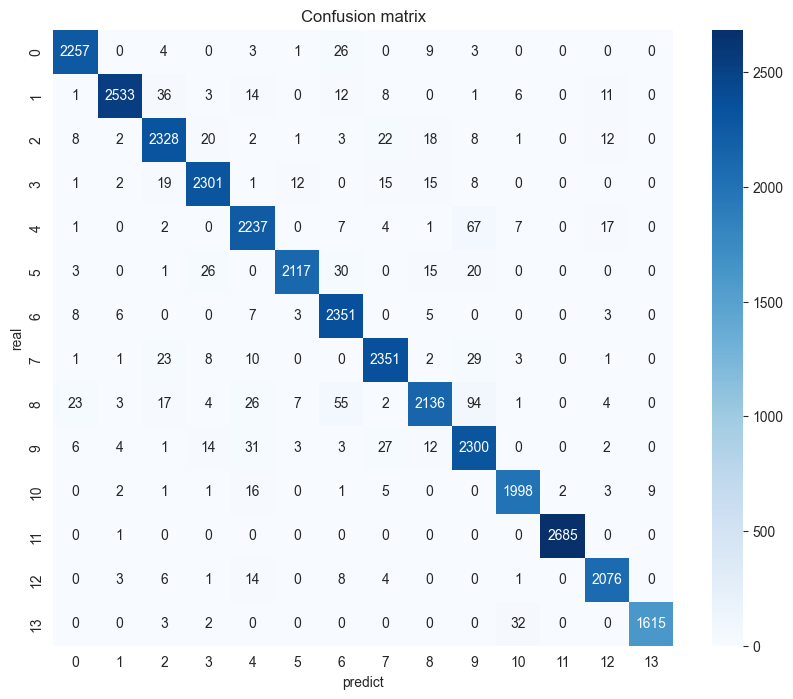

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# 评估模型
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f'\n测试集的总体准确率: {test_acc:.2f}')

# 获取预测结果
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# 计算混淆矩阵
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)

# 绘制混淆矩阵图
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(NUM), yticklabels=range(NUM))
plt.xlabel('predict')
plt.ylabel('real')
plt.title('Confusion matrix')
plt.show()


In [10]:

# 评估模型
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f'\n测试集的总体准确率: {test_acc:.2f}')

# 获取预测结果
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# 计算每种类别的错误率
error_rates = {}
for label in range(NUM):
    label_indices = np.where(y_test_classes == label)[0]
    label_correct = np.sum(y_pred_classes[label_indices] == y_test_classes[label_indices])
    label_total = len(label_indices)
    label_error_rate = 1 - (label_correct / label_total)
    error_rates[label] = label_error_rate

print("\n每种类别的错误率:")
for label, error_rate in error_rates.items():
    print(f'类别 {label}: {error_rate:.2f}')
    

1012/1012 [==============================] - 3s 3ms/step - loss: 0.1896 - categorical_accuracy: 0.9668

测试集的总体准确率: 0.97
1012/1012 [==============================] - 2s 2ms/step

每种类别的错误率:
类别 0: 0.02
类别 1: 0.04
类别 2: 0.04
类别 3: 0.03
类别 4: 0.05
类别 5: 0.04
类别 6: 0.01
类别 7: 0.03
类别 8: 0.10
类别 9: 0.04
类别 10: 0.02
类别 11: 0.00
类别 12: 0.02
类别 13: 0.02


In [7]:
# 导出模型
# model.save("mnist.h5")
model.export("mnist")
# 调用转换脚本
!python tools/h5_to_tflite.py mnist mnist.tflite 1 data/mnist14  0to1
!python tools/tflite2tmdl.py mnist.tflite mnist.tmdl int8 1 28,28,1 14 1

INFO:tensorflow:Assets written to: mnist\assets


INFO:tensorflow:Assets written to: mnist\assets


Saved artifact at 'mnist'. The following endpoints are available:

* Endpoint 'serve'
  Args:
    args_0: float32 Tensor, shape=(None, 28, 28, 1)
  Returns:
    float32 Tensor, shape=(None, 14)
Done, quant used time:17.283387899398804


2024-11-10 07:23:07.866779: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE SSE2 SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Instructions for updating:
Use `tf.saved_model.load` instead.
2024-11-10 07:23:07.904154: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:382] MLIR V1 optimization pass is not enabled
2024-11-10 07:23:08.079163: I tensorflow/core/grappler/devices.cc:75] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2024-11-10 07:23:08.079318: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for 

CONV_2D
{'dilation_h_factor': 1, 'dilation_w_factor': 1, 'fused_activation_function': 1, 'padding': 0, 'stride_h': 2, 'stride_w': 2}
    input: serving_default_ftr0a_input
    output: sequential_1/relu0/Relu;StatefulPartitionedCall_1/StatefulPartitionedCall/sequential_1/relu0/Relu;sequential_1/bn0/FusedBatchNormV3;StatefulPartitionedCall_1/StatefulPartitionedCall/sequential_1/bn0/FusedBatchNormV3;ftr0a/bias;sequential_1/ftr0a/BiasAdd;StatefulPartitionedCall_1/StatefulPartitionedCall/sequential_1/ftr0a/BiasAdd;sequential_1/ftr0a/Conv2D;StatefulPartitionedCall_1/StatefulPartitionedCall/sequential_1/ftr0a/Conv2D1
    filter 9: sequential_1/ftr0a/Conv2D;StatefulPartitionedCall_1/StatefulPartitionedCall/sequential_1/ftr0a/Conv2D 
    bias 8: sequential_1/relu0/Relu;StatefulPartitionedCall_1/StatefulPartitionedCall/sequential_1/relu0/Relu;sequential_1/bn0/FusedBatchNormV3;StatefulPartitionedCall_1/StatefulPartitionedCall/sequential_1/bn0/FusedBatchNormV3;ftr0a/bias;sequential_1/ftr0a/BiasAdd

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
